# Sample Project Coronavirus

The goal of this project is to explore a dataset of coronavirus patients to train a model which predicts whether a patient will die or recover from Coronavirus. 

## About the data

The dataset confirmed-positive-on data comes from https://howsmyflattening.ca/#/data/. 

The site is set up by a group of physicians, medical students, computational health researchers, designers and epidemiologists who aim to rapidly filter and present emergent COVID-19 data to help Ontario #FlattenTheCurve. They intend to connect experts and present data in an easy to digest, actionable way to help Ontario's public leaders and individuals act decisively as evidence grows and time ticks by.

### Confirmed positive cases of COVID19 in Ontario

The dataset includes compiled daily reported data from public health units on confirmed positive cases of COVID-19 in Ontario. It includes data on patients from 1st January 2020 to 28th June 2020 and is updated daily. Currently, the dataset inludes data from 37,947 patients. Case data is as initially reported.

The following are the features which we will use for predicting the outcome variable (recovered or diseased).

1. accurate_episode_date - date of diagnosis
2. age_group - categorized to <20, 30s, 40s, 50s, 60s, 70s, 80s or 90s
3. client_gender - female, male, unkown, other,or transgender
4. outbreak_related - Yes or no entry
5. reporting_phu_latitude - Latitude of the reporting public health unit
6. reporting_phu_longitude - longitude of the reporting public health unit




## Load necessary packages

In [12]:
# Exploratory Data Analysis and plotting libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Data Cleaning with Scikit Learn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# convert data time
from datetime import date
from datetime import datetime

# Models from Skikit Learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


# Model Evaluation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import plot_roc_curve, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix



## Load Data

In [13]:
df = pd.read_csv("confirmed_positive_on.csv", sep =";")
df.shape

(37947, 18)

## Explorative Data Anlysis

In [3]:
df.head()

,id,row_id,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_address,reporting_phu_city,reporting_phu_postal_code,reporting_phu_website,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,specimen_reported_date,test_reported_date
0,4066,4066,2020-03-28,20s,FEMALE,Travel,Resolved,NaN,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,www.wechu.org,42.308796,-83.033670,2020-04-03,2020-03-30,2020-04-03
1,1091,1091,2020-03-13,30s,MALE,Travel,Resolved,NaN,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912,2020-03-26,2020-03-17,2020-03-26
2,34119,33188,2020-04-12,20s,FEMALE,No Epi-link,Resolved,NaN,Middlesex-London Health Unit,50 King Street,London,N6A 5L7,www.healthunit.com,42.981468,-81.254016,2020-05-20,2020-05-17,2020-05-20
3,9095,9095,2020-04-12,30s,FEMALE,CC,Resolved,NaN,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,www.regionofwaterloo.ca,43.462876,-80.520913,2020-04-15,2020-04-14,2020-04-15
4,1713,1713,2020-03-23,30s,MALE,CC,Resolved,NaN,Eastern Ontario Health Unit,1000 Pitt Street,Cornwall,K6J 5T1,www.eohu.ca,45.029152,-74.736298,2020-04-01,2020-03-24,2020-04-01


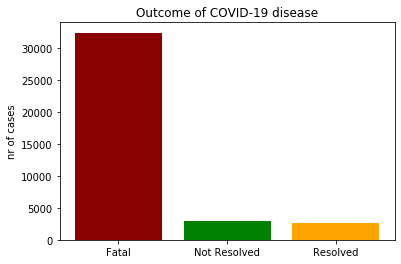

In [80]:
# plot frequency of target variable categories

fig, ax = plt.subplots()
ax.bar(x = list(set(df["outcome1"])), height = df["outcome1"].value_counts(), color=['darkred', 'g', 'orange'])
ax.set_ylabel("nr of cases")
ax.set_title("Outcome of COVID-19 disease")

plt.show()



In [81]:
df["outcome1"].value_counts(normalize = True)

Resolved        0.854033
Fatal           0.075895
Not Resolved    0.070071
Name: outcome1, dtype: float64

The dataset is highly unbalanced with approximately 85 % recoveries, 8 % fatal outcomes and 7 % not yet resolved cases. For now, we shall exclude unresolved cases from our analysis and label "Fatal" outcome as 1 and Resolved as 0.

In [14]:
df.drop(df[df["outcome1"] == "Not Resolved"].index, inplace = True)
df["outcome1"].replace({"Fatal": 1, "Resolved": 0}, inplace = True)

In [15]:
df["outcome1"].value_counts(normalize = True)

0    0.918386
1    0.081614
Name: outcome1, dtype: float64

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35288 entries, 0 to 37946
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         35288 non-null  int64  
 1   row_id                     35288 non-null  int64  
 2   accurate_episode_date      35286 non-null  object 
 3   age_group                  35288 non-null  object 
 4   client_gender              35288 non-null  object 
 5   case_acquisitionInfo       35288 non-null  object 
 6   outcome1                   35288 non-null  int64  
 7   outbreak_related           14676 non-null  object 
 8   reporting_phu              35288 non-null  object 
 9   reporting_phu_address      35288 non-null  object 
 10  reporting_phu_city         35288 non-null  object 
 11  reporting_phu_postal_code  35288 non-null  object 
 12  reporting_phu_website      35288 non-null  object 
 13  reporting_phu_latitude     35288 non-null  flo

### COVID 19 outcome according to Gender

In [85]:
df.client_gender.value_counts()

FEMALE         19006
MALE           16005
UNKNOWN          262
OTHER              8
TRANSGENDER        7
Name: client_gender, dtype: int64

In [86]:
pd.crosstab(df.outcome1, df.client_gender)

client_gender,FEMALE,MALE,OTHER,TRANSGENDER,UNKNOWN
outcome1,,,,,
0,17462,14712,8,6,220
1,1544,1293,0,1,42


In [16]:
female_fatal = sum((df.client_gender == "FEMALE") & (df.outcome1 == 1))
female_resolved = sum((df.client_gender == "FEMALE") & (df.outcome1 == 0))
mortality_rate_female = female_fatal / female_resolved
mortality_rate_female


0.08842057038139961

In [17]:
male_fatal = sum((df.client_gender == "MALE") & (df.outcome1 == 1))
male_resolved = sum((df.client_gender == "MALE") & (df.outcome1 == 0))
mortality_rate_male = male_fatal / male_resolved
mortality_rate_male

0.08788743882544861

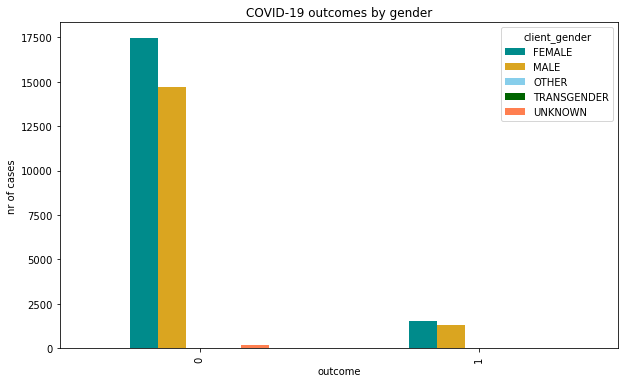

In [18]:
# Plotting the data
pd.crosstab(df.outcome1, df.client_gender).plot(kind="bar", figsize=(10,6), color=["darkcyan", "goldenrod", "skyblue", "darkgreen", "coral"])

plt.title("COVID-19 outcomes by gender")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

### Plot COVID-19 outcomes for different age groups

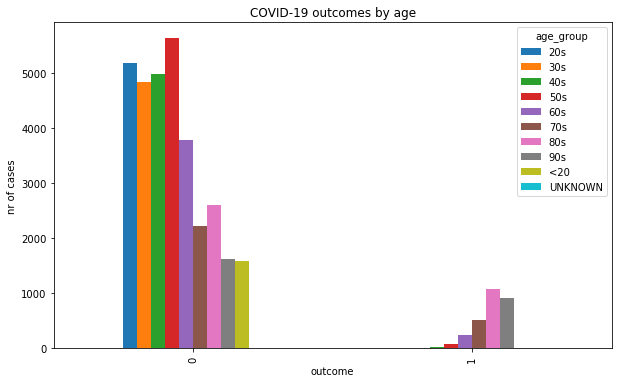

In [19]:
pd.crosstab(df.outcome1, df.age_group).plot(kind="bar", figsize=(10,6))

plt.title("COVID-19 outcomes by age")
plt.xlabel("outcome")
plt.ylabel("nr of cases");

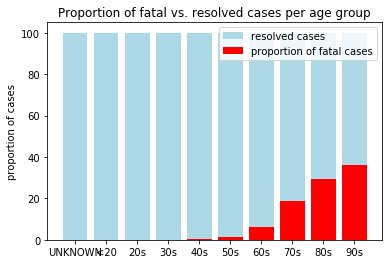

In [20]:
# calculate relative frequencies of fatal/resolved outcome for each age group

age_groups_ordered = ["UNKNOWN", "<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"]

df.age_group = pd.Categorical(df.age_group, categories=
    ["UNKNOWN", "<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],
    ordered=True)
freq_per_age = df.age_group.value_counts()

freq_per_age = freq_per_age.sort_index()
freq_fatal_per_age = df.age_group[df.outcome1 == 1].value_counts()

rel_freq_fatal_per_age = (freq_fatal_per_age / freq_per_age) * 100
rel_freq_resolved_per_age = 100 - rel_freq_fatal_per_age

# plot the relative frequencies per age group
fig, ax = plt.subplots()
ax.bar(rel_freq_fatal_per_age.index, 100, color = "lightblue", zorder = 1, label="resolved cases")
ax.bar(rel_freq_fatal_per_age.index, rel_freq_fatal_per_age, color = "red", zorder = 2, label="proportion of fatal cases")
ax.set_ylabel("proportion of cases")
ax.set_title("Proportion of fatal vs. resolved cases per age group")
ax.legend()

plt.show();

## Modeling

In [92]:
df.head()


,id,row_id,accurate_episode_date,age_group,client_gender,case_acquisitionInfo,outcome1,outbreak_related,reporting_phu,reporting_phu_address,reporting_phu_city,reporting_phu_postal_code,reporting_phu_website,reporting_phu_latitude,reporting_phu_longitude,case_reported_date,specimen_reported_date,test_reported_date
0,4066,4066,2020-03-28,20s,FEMALE,Travel,0,NaN,Windsor-Essex County Health Unit,1005 Ouellette Avenue,Windsor,N9A 4J8,www.wechu.org,42.308796,-83.033670,2020-04-03,2020-03-30,2020-04-03
1,1091,1091,2020-03-13,30s,MALE,Travel,0,NaN,Ottawa Public Health,100 Constellation Drive,Ottawa,K2G 6J8,www.ottawapublichealth.ca,45.345665,-75.763912,2020-03-26,2020-03-17,2020-03-26
2,34119,33188,2020-04-12,20s,FEMALE,No Epi-link,0,NaN,Middlesex-London Health Unit,50 King Street,London,N6A 5L7,www.healthunit.com,42.981468,-81.254016,2020-05-20,2020-05-17,2020-05-20
3,9095,9095,2020-04-12,30s,FEMALE,CC,0,NaN,"Region of Waterloo, Public Health",99 Regina Street South,Waterloo,N2J 4V3,www.regionofwaterloo.ca,43.462876,-80.520913,2020-04-15,2020-04-14,2020-04-15
4,1713,1713,2020-03-23,30s,MALE,CC,0,NaN,Eastern Ontario Health Unit,1000 Pitt Street,Cornwall,K6J 5T1,www.eohu.ca,45.029152,-74.736298,2020-04-01,2020-03-24,2020-04-01


Split data into target variable ("outcome1") and predictor variables. 

### Transform the features

In [93]:
df.dtypes

id                              int64
row_id                          int64
accurate_episode_date          object
age_group                    category
client_gender                  object
case_acquisitionInfo           object
outcome1                        int64
outbreak_related               object
reporting_phu                  object
reporting_phu_address          object
reporting_phu_city             object
reporting_phu_postal_code      object
reporting_phu_website          object
reporting_phu_latitude        float64
reporting_phu_longitude       float64
case_reported_date             object
specimen_reported_date         object
test_reported_date             object
dtype: object

In [94]:
df.isna().sum()

id                               0
row_id                           0
accurate_episode_date            2
age_group                        0
client_gender                    0
case_acquisitionInfo             0
outcome1                         0
outbreak_related             20612
reporting_phu                    0
reporting_phu_address            0
reporting_phu_city               0
reporting_phu_postal_code        0
reporting_phu_website            0
reporting_phu_latitude           0
reporting_phu_longitude          0
case_reported_date               0
specimen_reported_date         329
test_reported_date             447
dtype: int64

Since there is only two missing values for accurate_episode_date, we exclude these data points.

In [21]:
df.dropna(subset = ["accurate_episode_date"], inplace = True)

The id, row_id, case_acquisitionInfo and reporting_phu_website columns are not relevant for our analyis. We also drop the columns with information on the reporting phu address since this information is redundant. Also, we only keep one date ("accurate episode_date") to prevent redundancies and avoid more missing data points.

In [22]:
df.drop(columns=["id", "row_id", "case_acquisitionInfo", "reporting_phu_address", "reporting_phu_website", "specimen_reported_date", "case_reported_date", "test_reported_date"], axis =1, inplace =True)


In [97]:
df.head()

,accurate_episode_date,age_group,client_gender,outcome1,outbreak_related,reporting_phu,reporting_phu_city,reporting_phu_postal_code,reporting_phu_latitude,reporting_phu_longitude
0,2020-03-28,20s,FEMALE,0,NaN,Windsor-Essex County Health Unit,Windsor,N9A 4J8,42.308796,-83.033670
1,2020-03-13,30s,MALE,0,NaN,Ottawa Public Health,Ottawa,K2G 6J8,45.345665,-75.763912
2,2020-04-12,20s,FEMALE,0,NaN,Middlesex-London Health Unit,London,N6A 5L7,42.981468,-81.254016
3,2020-04-12,30s,FEMALE,0,NaN,"Region of Waterloo, Public Health",Waterloo,N2J 4V3,43.462876,-80.520913
4,2020-03-23,30s,MALE,0,NaN,Eastern Ontario Health Unit,Cornwall,K6J 5T1,45.029152,-74.736298


#### Define custom transformer for the data

In [97]:
# custom transformer that calculates numbers of days from first of january
from datetime import date
from datetime import datetime

from sklearn.base import BaseEstimator, TransformerMixin
class CustomDateTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):
        d0 = pd.to_datetime('2020-01-01')
        transformed_X = pd.DataFrame(X.copy())

        
        transformed_X = (transformed_X.apply(pd.to_datetime) - d0)
        transformed_X = transformed_X.astype('timedelta64[D]')

        return transformed_X

In [98]:
# custom transformer that assigns numbers to the age_groups
class CustomAgeTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):

        transformed_X = pd.DataFrame(X.copy())

        transformed_X = transformed_X.replace({'80s':80, '20s':20, '<20':10, '60s':60, '50s':50, '70s':70, '30s':30, '40s':40, '90s':90})


        return transformed_X



In [99]:
# Define different features and transformer pipeline
categorical_features = ["client_gender", "outbreak_related", "reporting_phu", "reporting_phu_city", "reporting_phu_postal_code"]
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

age_features = ["age_group"]
age_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(missing_values="UNKNOWN",strategy="most_frequent")),
    ("age_transformer", CustomAgeTransformer()),
    ("scaler", StandardScaler())
])

date_features = ["accurate_episode_date"]
date_transformer = Pipeline(steps=[
    ("date_transformer", CustomDateTransformer()), 
    ("scaler", StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ("age_transformer", age_transformer, age_features),
        ("date_transformer", date_transformer, date_features),
        ("cat_transformer", categorical_transformer, categorical_features)])



### Fit models

First, we split the data into training and test set. 

In [26]:
X = df.drop("outcome1", axis=1)
y = df.outcome1

In [27]:
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size = 0.2)


To begin with, we try out KNN, Logistic Regression and Random Forest. 

In [28]:
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(max_iter = 1000), 
          "Random Forest": RandomForestClassifier()}

def fit_and_score(models, X_train, X_test, y_train, y_test):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data
    X_test : testing data
    y_train : labels assosciated with training data
    y_test : labels assosciated with test data
    """
    # Random seed for reproducible results
    np.random.seed(7)
    # Make a list to keep model scores
    #model_scores = {}
    model_classification_report = {}
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        clf = Pipeline(steps=[("preprocessor", preprocessor),
                        ("model", model)])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        # Evaluate the model and append its score to model_scores
        #model_scores[name] = clf.score(X_test, y_test)
        model_classification_report[name] = classification_report(y_test, y_pred)
        
    return model_classification_report

In [29]:
model_scores = fit_and_score(models=models,
                             X_train=X_train,
                             X_test=X_test,
                             y_train=y_train,
                             y_test=y_test)


In [30]:
for clf in model_scores:
    print(clf, model_scores[clf], sep = "\n\n")


KNN

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      6467
           1       0.39      0.21      0.27       591

    accuracy                           0.91      7058
   macro avg       0.66      0.59      0.61      7058
weighted avg       0.89      0.91      0.89      7058

Logistic Regression

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6467
           1       0.52      0.10      0.17       591

    accuracy                           0.92      7058
   macro avg       0.72      0.55      0.56      7058
weighted avg       0.89      0.92      0.89      7058

Random Forest

              precision    recall  f1-score   support

           0       0.93      0.96      0.95      6467
           1       0.41      0.27      0.32       591

    accuracy                           0.91      7058
   macro avg       0.67      0.62      0.64      7058
weighted avg       0.89      0.91

All three classifiers have low sensitivity (i.e., recall for class 1). In the following, we try to improve the sensitivity by tuning the hyperparameters of the three classifiers. 

## Hyperparameter Tuning

### Tuning KNN by hand

In [34]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y,
                                                   test_size=0.2)

# since the class imbalance affects KNN, we oversample the minority class to compensate
oversample = SMOTE()

X_train = preprocessor.fit_transform(X_train)

X_train, y_train = oversample.fit_resample(X_train, y_train)

X_test = preprocessor.transform(X_test)

In [35]:
# Create a list of train scores
train_scores = []

# Create a list of test scores
test_scores = []

# Create a dictionary for classification_reports
classification_reports = {}

# Create a list of different values for n_neighbors
neighbors = [2,5,10,20] # 1 to 20

# Setup algorithm
knn = KNeighborsClassifier()

# Loop through different neighbors values
for i in neighbors:
    knn.set_params(n_neighbors = i) # set neighbors value
    
    #model = Pipeline(steps=[("preprocessor", preprocessor),
     #                   ("knn", knn.set_params(n_neighbors = i))])
    
    knn.fit(X_train, y_train)
    
    # Update the training scores
    train_scores.append(knn.score(X_train, y_train))
    
    # Update the test scores
    test_scores.append(knn.score(X_test, y_test))
    
    # update the classification reports
    classification_reports[i] = classification_report(y_test, knn.predict(X_test))

In [38]:
test_scores

[0.903655426466421, 0.8498158118447152, 0.8360725417965429, 0.8134032303768773]

Maximum KNN score on the test data: 90.37%


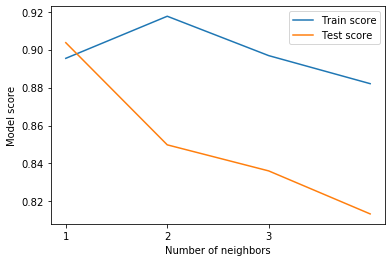

In [37]:
# Plot test vs. train accuracy for KNN
plt.plot(range(1,5), train_scores, label="Train score")
plt.plot(range(1,5), test_scores, label="Test score")
plt.xticks(np.arange(1, 4, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(test_scores)*100:.2f}%")

In [45]:
for i in classification_reports:
    print(i, "neighbours:\n", classification_reports[i])

2 neighbours:
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      6533
           1       0.34      0.31      0.32       525

    accuracy                           0.90      7058
   macro avg       0.64      0.63      0.64      7058
weighted avg       0.90      0.90      0.90      7058

5 neighbours:
               precision    recall  f1-score   support

           0       0.97      0.87      0.91      6533
           1       0.28      0.65      0.39       525

    accuracy                           0.85      7058
   macro avg       0.62      0.76      0.65      7058
weighted avg       0.92      0.85      0.88      7058

10 neighbours:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      6533
           1       0.27      0.71      0.39       525

    accuracy                           0.84      7058
   macro avg       0.62      0.78      0.65      7058
weighted avg       0.92     

For any of the hyperparameters we tried, the F1 score is not satisfactory, meaning that either recall or precision are low in each case. Next, we try to tune logistic regression and the RandomForestClassifier.

### Tuning Logistic Regression and RandomForestClassifier using RandomizedSearchCV

In [47]:
# Different LogisticRegression hyperparameters
log_reg_grid = {"C": np.logspace(-4, 4, 20),
                "solver": ["liblinear"]}

# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2)}

In [52]:
np.random.seed(7)

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2)

X_train = preprocessor.fit_transform(X_train)

X_test = preprocessor.transform(X_test)

In [53]:
# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(LogisticRegression(),
                                param_distributions=log_reg_grid,
                                cv=5,
                                n_iter=20,
                                verbose=True)

# Fit random hyperparameter search model
rs_log_reg.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    5.6s finished


In [54]:
rs_log_reg.best_params_


{'solver': 'liblinear', 'C': 0.012742749857031334}

In [55]:
rs_log_reg.score(X_test, y_test)


0.9172570133182204

In [56]:
# Random Forest Classifier
# Setup random seed
np.random.seed(7)

# Setup random hyperparameter search for RandomForestClassifier
rs_rf = RandomizedSearchCV(RandomForestClassifier(),
                           param_distributions=rf_grid,
                           cv=5,
                           n_iter=20,
                           verbose=True)

# Fit random hyperparameter search model
rs_rf.fit(X_train, y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 14.8min finished


In [57]:
# Find the best parameters
rs_rf.best_params_

{'n_estimators': 860,
 'min_samples_split': 18,
 'min_samples_leaf': 5,
 'max_depth': None}

In [58]:
# Evaluate the randomized search random forest model
rs_rf.score(X_test, y_test)

0.9169736469254747

## Further evaluation metrics

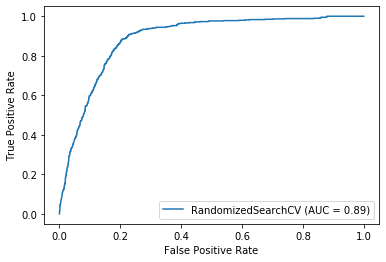

In [59]:
# ROC Curve
plot_roc_curve(rs_rf, X_test, y_test);

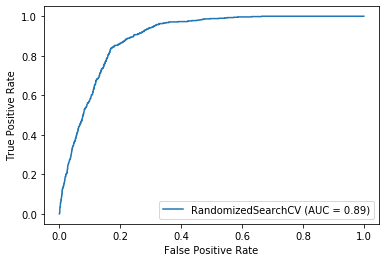

In [60]:
plot_roc_curve(rs_log_reg, X_test, y_test);

Confusion matrix, without normalization
[[6433   34]
 [ 550   41]]
Normalized confusion matrix
[[0.99474254 0.00525746]
 [0.93062606 0.06937394]]


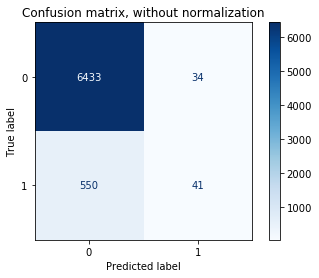

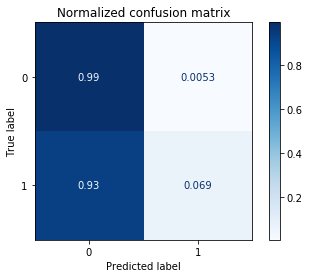

In [62]:
# plot_confusion_matrix for logistic regression

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rs_log_reg, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Confusion matrix, without normalization
[[6432   35]
 [ 551   40]]
Normalized confusion matrix
[[0.99458791 0.00541209]
 [0.9323181  0.0676819 ]]


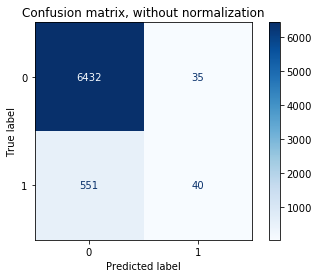

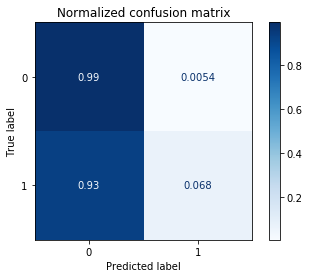

In [63]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rs_rf, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [65]:
# classification report
y_preds = rs_log_reg.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6467
           1       0.55      0.07      0.12       591

    accuracy                           0.92      7058
   macro avg       0.73      0.53      0.54      7058
weighted avg       0.89      0.92      0.89      7058



In [66]:
# classification report
y_preds = rs_rf.predict(X_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      6467
           1       0.53      0.07      0.12       591

    accuracy                           0.92      7058
   macro avg       0.73      0.53      0.54      7058
weighted avg       0.89      0.92      0.89      7058



The evaluation metrics reveal that the trained classifiers perform very poorly on predicting fatal outcomes. Therefore, we train logistic regression again whilst accounting for class imbalance.

## Acounting for class imbalance

In [77]:
# logistic regression accounting for class labels
np.random.seed(42)


# set class weights to be the inverse of class probabilities
w = {1:92, 0:8}
# Setup random hyperparameter search for LogisticRegression
log_reg2 = LogisticRegression(C = 0.0127, class_weight=w, random_state=13, max_iter=1000)

# Fit random hyperparameter search model
log_reg2.fit(X_train, y_train)
log_reg2.score(X_test, y_test)

0.8104278832530462

#### Evaluating the final logistic regression model

In [85]:
y_pred = log_reg2.predict(X_test)

Area Under Curve: 0.8358237853143264


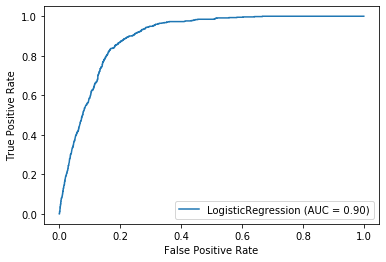

In [86]:
# ROC curve
plot_roc_curve(log_reg2, X_test, y_test)
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred)}')

In [101]:
# accuracy
X = df.drop("outcome1", axis=1)
X = preprocessor.fit_transform(X)

cv_acc = cross_val_score(log_reg2,
                        X, 
                        y, 
                        cv=5, 
                        scoring="accuracy")

print(f'Accuracy Score: {np.mean(cv_acc)}')


Accuracy Score: 0.8070623763032614


In [88]:
# classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      6467
           1       0.29      0.87      0.43       591

    accuracy                           0.81      7058
   macro avg       0.64      0.84      0.66      7058
weighted avg       0.93      0.81      0.85      7058



normalized confusion matrix
[[0.80531931 0.19468069]
 [0.13367174 0.86632826]]


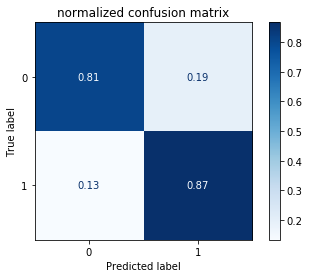

In [90]:
# Confusion Matrix

title = "normalized confusion matrix"

disp = plot_confusion_matrix(log_reg2, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true'
                            )
disp.ax_.set_title(title)

print(title)
print(disp.confusion_matrix)

plt.show()

The performance of the ML model is now better than before. However, accuracy is relatively low (around 80 %) and the F1 score is still not great. This makes us assume that maybe the data does not offer enough information to answer the research question. 

## Feature importance